# EKSTRAKSI PALET WARNA UNTUK KOMPRESI GAMBAR DIGITAL MENGGUNAKAN ALGORITMA K-MEANS

TUGAS AKHIR

Ahmad Ma'ruf  
NIM. 2020150012

Teknik Informatika  
Fakultas Teknik dan Ilmu Komputer  
Universitas Sains Al-Qur'an Jawa Tengah di Wonosobo  
2024

### Dataset Gambar
https://drive.google.com/drive/folders/13cc9m-1gNY--0HOwyTi2XadrwHo5KsvH?usp=sharing

---

**Percobaan ini merupakan replikasi dari penelitian dalam skripsi saya. Saya mengulang proses analisis data dari hasil eksperimen guna mengevaluasi apakah terdapat perbedaan kesimpulan dibandingkan dengan hasil yang diperoleh sebelumnya.**

**Replikasi ini dilakukan pada tanggal 8 Juni 2025**

** Pengulangan proses analisis data ini muncul karena keresahan saya terhadap skripsi saya yang saya rasa masih ada kekurangan. Khususnya dengan fakta bahwa sebaran masing-masing variabelnya sangat luas. Khususnya variabel waktu Komputasi (`comp_time`) yang berada di rentang nol hingga puluhan detik.

Oleh karena itu dengan pendekatan yang sedikit berbeda diharapkan dapat menghasilkan kesimpulan/output penelitian yang lebih baik

# Langkah-Langkah Analisis Data untuk Menentukan Nilai K Optimal

## Tujuan
Menemukan nilai `K` (jumlah centroid) terbaik dalam eksperimen kompresi gambar menggunakan algoritma KMeans. Fokus pada keseimbangan antara:
- Kualitas gambar hasil kompresi (`PSNR`)
- Rasio kompresi (`CR`)
- Waktu eksekusi kompresi (`comp_time`)

Dengan batasan bahwa `CR >= 0.67`, sebagai standar minimal sebanding dengan JPEG.

---

## Langkah 1: Pemahaman Struktur Data

Identifikasi kolom-kolom berikut dari file CSV:
- `id`: ID unik tiap percobaan
- `img_type`: Jenis gambar
- `k`: Jumlah centroid
- `mse`: Mean Squared Error
- `psnr`: Peak Signal to Noise Ratio
- `original_size`: Ukuran asli file gambar (bytes)
- `compressed_size`: Ukuran file setelah kompresi (bytes)
- `cr`: Compression Ratio = compressed_size / original_size
- `comp_time`: Waktu komputasi kompresi (detik)

Pahami makna dan hubungan antar variabel agar bisa melakukan analisis yang tepat.

---

## Langkah 2: Eksplorasi Awal (EDA)

Lakukan visualisasi awal:
- Plot trend antara `K` vs `PSNR`
- Plot `K` vs `comp_time`
- Plot `K` vs `CR`

Cari pola umum:
- Apakah PSNR meningkat secara signifikan dengan peningkatan `K`?
- Bagaimana pengaruh `K` terhadap waktu komputasi?

Gunakan scatter plot atau line plot untuk memvisualisasikan hubungan antara metrik-metrik ini.

---

## Langkah 3: Kelompokkan Data Berdasarkan `K`

Hitung statistik agregat per nilai `K`:
- Median dari `PSNR`, `comp_time`, dan `CR` (lebih stabil daripada mean)

Hasilkan dataframe baru yang berisi satu baris per nilai `K`.

---

## Langkah 4: Filter Kandidat K

Terapkan aturan penyaringan untuk menyempitkan nilai `K` yang layak:

### a. Filter awal berdasarkan standar industri
- `median_cr >= 0.67` (minimal sebanding dengan JPEG)

### b. Filter lanjutan berdasarkan performa
- Ambil top 50% dari `median_psnr` (PSNR tinggi)
- Ambil bottom 50% dari `median_comp_time` (waktu rendah)

---

## Langkah 5: Tentukan Strategi Prioritas

Jika ada lebih dari satu calon `K`, pilih berdasarkan strategi berikut:

### a. Prioritaskan kecepatan
- Pilih nilai `K` terkecil di antara kandidat

### b. Prioritaskan kualitas
- Pilih nilai `K` dengan `median_psnr` tertinggi

### c. Balance antara keduanya
- Buat skor sederhana: `score = median_psnr - median_comp_time`
- Pilih nilai `K` dengan skor tertinggi

---

## Langkah 6: Analisis Sensitivitas Per Jenis Gambar

Lakukan analisis yang sama per kelompok gambar (`img_type`) atau jenis resolusi:
- Apakah nilai `K` yang dipilih selalu muncul sebagai kandidat?
- Jika ya → itu indikasi kuat bahwa nilai `K` tersebut stabil dan generalizable

---

## Langkah 7: Analisis Elbow Point (Opsional Tapi Kuat)

Cari titik elbow pada grafik:
- `PSNR vs K`: Titik di mana peningkatan PSNR mulai melambat
- `comp_time vs K`: Titik di mana waktu mulai naik drastis

Nilai `K` yang berada di "elbow" bisa jadi nilai optimal karena memberikan manfaat terbesar dengan biaya minimal.

---

## Langkah 8: Validasi Hasil Akhir

Pastikan hasil akhir:
- Dapat dipertanggungjawabkan secara statistik
- Didukung oleh visualisasi
- Stabil di berbagai jenis gambar/resolusi
- Masuk akal secara domain knowledge (misalnya: efisiensi kompresi ≥ JPEG)

---

## Output Akhir

Setelah semua langkah dilakukan, kamu akan memiliki:
- Nilai `K` optimal yang valid dan dapat dipertanggungjawabkan
- Penjelasan visual dan statistik mengapa nilai tersebut dipilih
- Analisis sensitivitas untuk berbagai jenis gambar/resolusi

In [143]:
# @title Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
# @title Source File
data_source = "result-250608_09-45.csv" # @param {type:"string"}

In [145]:
# @title Eksplorasi Struktu Dataset
dataset_df = pd.read_csv(data_source)
dataset_df.head()

,id,img_type,k,mse,psnr,original_size,compressed_size,cr,comp_time
0,a1_8_1,a,8,0.003449,72.75,85850,45141,0.47,0.32
1,a1_8_2,a,8,0.003451,72.75,85850,45248,0.47,0.16
2,a1_8_3,a,8,0.003170,73.12,85850,46270,0.46,0.21
3,a1_16_1,a,16,0.001484,76.42,85850,46141,0.46,0.22
4,a1_16_2,a,16,0.001484,76.42,85850,46091,0.46,0.28


In [146]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               216 non-null    object 
 1   img_type         216 non-null    object 
 2   k                216 non-null    int64  
 3   mse              216 non-null    float64
 4   psnr             216 non-null    float64
 5   original_size    216 non-null    int64  
 6   compressed_size  216 non-null    int64  
 7   cr               216 non-null    float64
 8   comp_time        216 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 15.3+ KB


- Dari ouput kode diatas dapat ditemukan bahwa jumlah data ada sebanyak 216, sesuai dengan jumlah percobaan yang dilakukan
- tidak ada data null/data yang tidak lengkap dataset tersebut

In [147]:
dataset_df.describe()

,k,mse,psnr,original_size,compressed_size,cr,comp_time
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,57.333333,0.000981,81.610648,188698.833333,60287.134259,0.668565,2.752917
std,43.531544,0.001470,6.069262,104417.311178,32702.858825,0.076488,3.317459
min,8.000000,0.000003,68.070000,41631.000000,14574.000000,0.460000,0.150000
25%,16.000000,0.000208,77.807500,85117.750000,34558.250000,0.657500,0.542500
50%,48.000000,0.000438,81.710000,201940.500000,53203.000000,0.690000,1.295000
75%,96.000000,0.001077,84.942500,253604.750000,85046.500000,0.720000,3.350000
max,128.000000,0.010138,102.700000,376351.000000,118952.000000,0.750000,16.310000


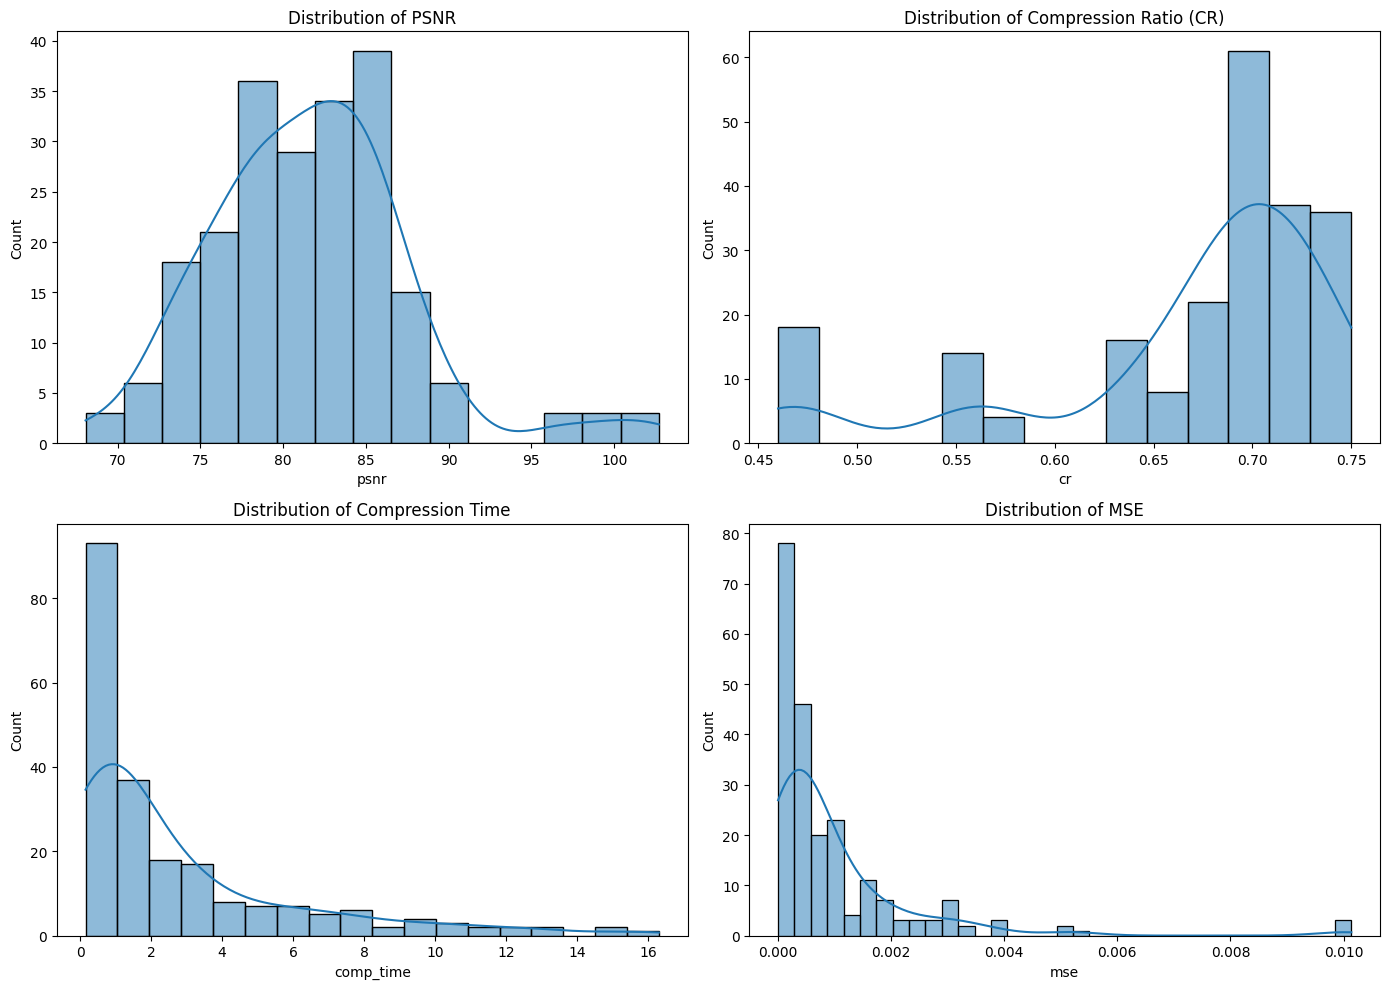

In [148]:
# @title Explanatory Data Analysis (EDA)

# Distribusi metrik utama
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(dataset_df['psnr'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of PSNR')

sns.histplot(dataset_df['cr'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Compression Ratio (CR)')

sns.histplot(dataset_df['comp_time'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Compression Time')

sns.histplot(dataset_df['mse'], ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution of MSE')

plt.tight_layout()
plt.show()

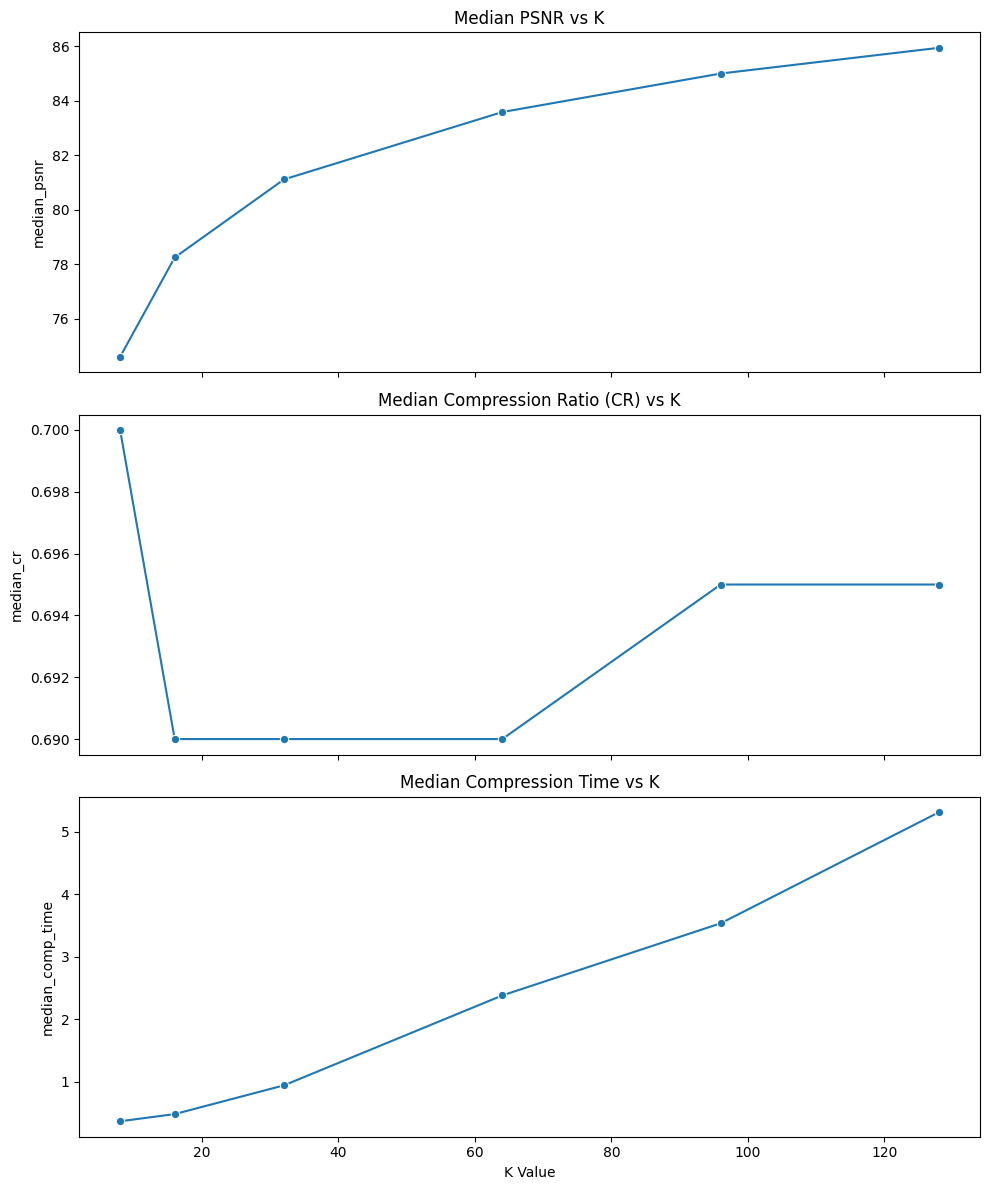

In [149]:
# @title Group by 'k' and calculate medians
grouped = dataset_df.groupby('k').agg(
    median_psnr=('psnr', 'median'),
    median_cr=('cr', 'median'),
    median_comp_time=('comp_time', 'median')
).reset_index()

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

sns.lineplot(data=grouped, x='k', y='median_psnr', ax=axes[0], marker='o')
axes[0].set_title('Median PSNR vs K')


sns.lineplot(data=grouped, x='k', y='median_cr', ax=axes[1], marker='o')
axes[1].set_title('Median Compression Ratio (CR) vs K')

sns.lineplot(data=grouped, x='k', y='median_comp_time', ax=axes[2], marker='o')
axes[2].set_title('Median Compression Time vs K')

plt.xlabel('K Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

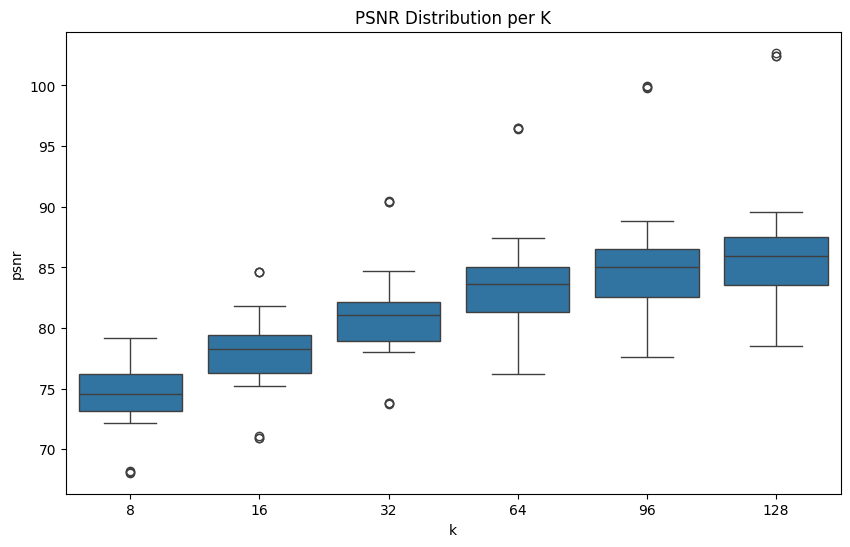

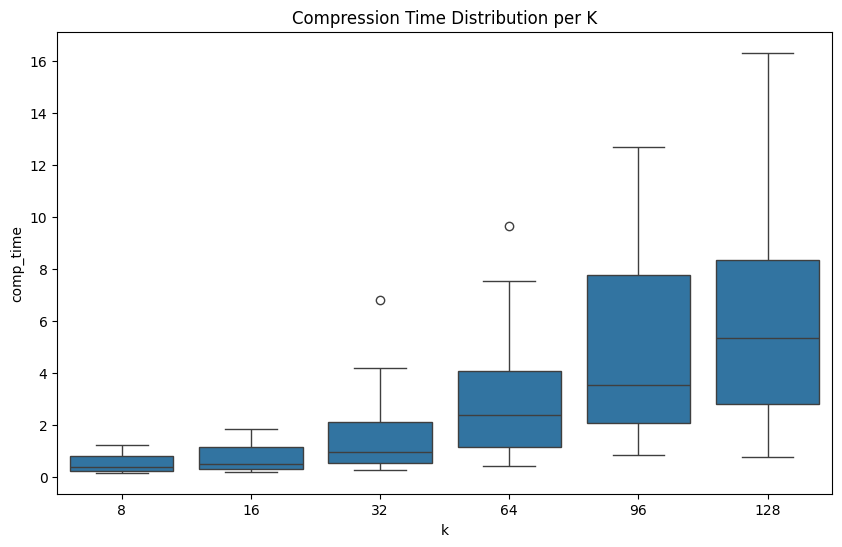

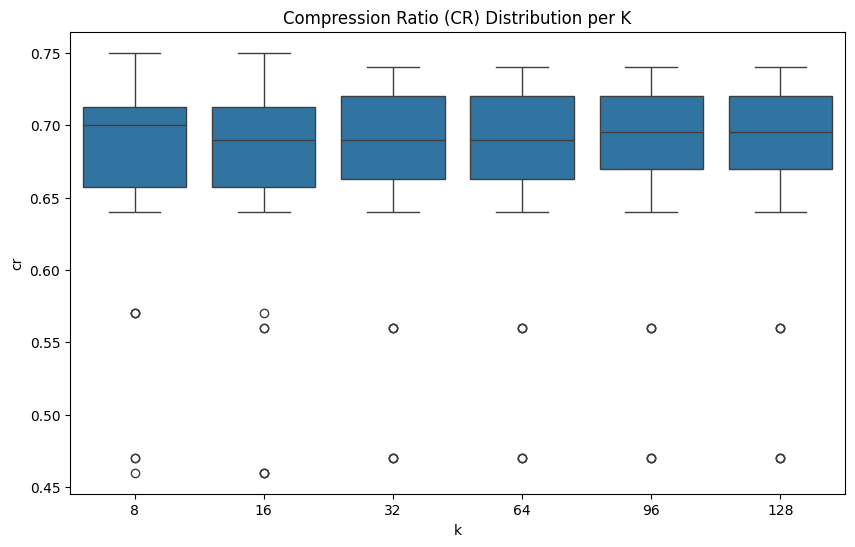

In [150]:
# Boxplot PSNR per K
plt.figure(figsize=(10, 6))
sns.boxplot(x='k', y='psnr', data=dataset_df)
plt.title('PSNR Distribution per K')
plt.xticks(rotation=0)
plt.show()

# Boxplot comp_time per K
plt.figure(figsize=(10, 6))
sns.boxplot(x='k', y='comp_time', data=dataset_df)
plt.title('Compression Time Distribution per K')
plt.xticks(rotation=0)
plt.show()

# Boxplot CR per K
plt.figure(figsize=(10, 6))
sns.boxplot(x='k', y='cr', data=dataset_df)
plt.title('Compression Ratio (CR) Distribution per K')
plt.xticks(rotation=0)
plt.show()

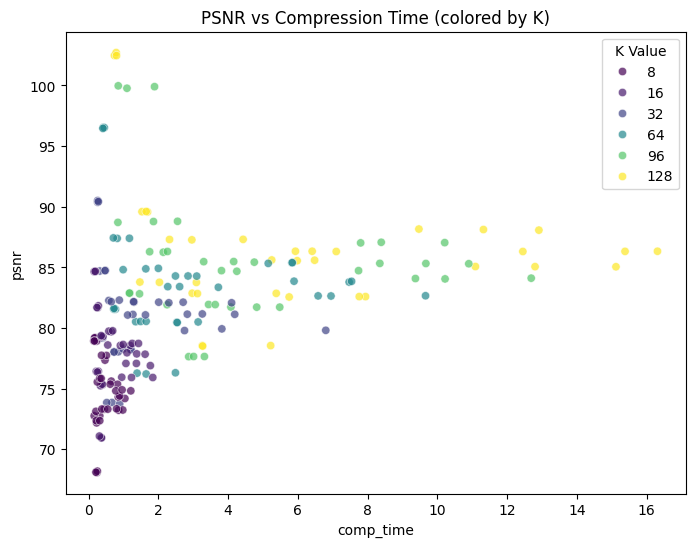

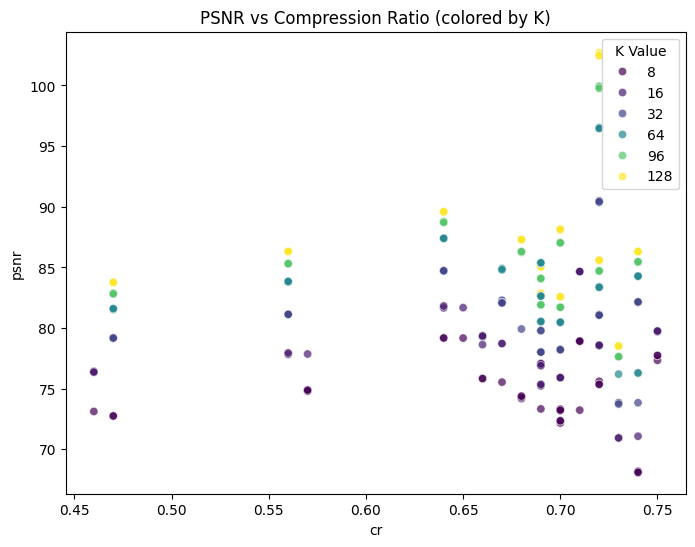

In [151]:
# @title Scatter plot antara PSNR dan Compression Time
plt.figure(figsize=(8, 6))
sns.scatterplot(x='comp_time', y='psnr', hue='k', data=dataset_df, palette='viridis', alpha=0.7)
plt.title('PSNR vs Compression Time (colored by K)')
plt.legend(title='K Value')
plt.show()

# Scatter plot antara PSNR dan CR
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cr', y='psnr', hue='k', data=dataset_df, palette='viridis', alpha=0.7)
plt.title('PSNR vs Compression Ratio (colored by K)')
plt.legend(title='K Value')
plt.show()

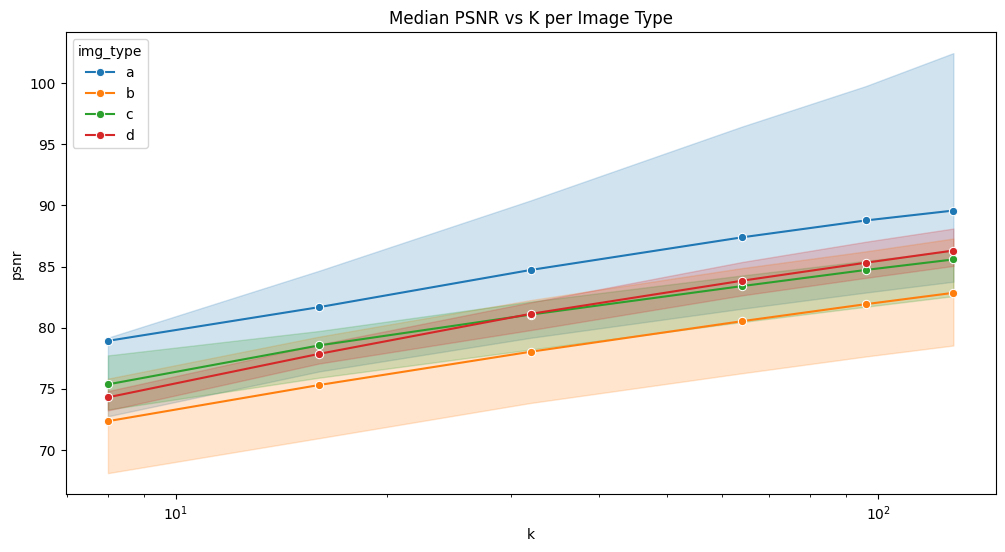

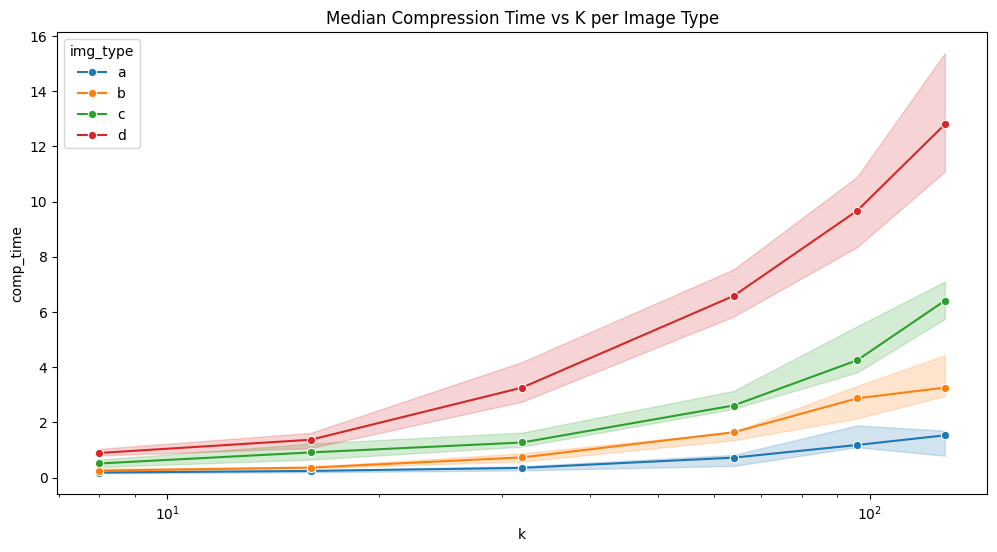

In [152]:
# Lineplot PSNR vs K per img_type
plt.figure(figsize=(12, 6))
sns.lineplot(data=dataset_df, x='k', y='psnr', hue='img_type', marker='o', estimator=np.median)
plt.title('Median PSNR vs K per Image Type')
plt.xscale('log')
plt.show()

# Lineplot comp_time vs K per img_type
plt.figure(figsize=(12, 6))
sns.lineplot(data=dataset_df, x='k', y='comp_time', hue='img_type', marker='o', estimator=np.median)
plt.title('Median Compression Time vs K per Image Type')
plt.xscale('log')
plt.show()

In [167]:
# @title Hitung statistik agregat per K
grouped = dataset_df.groupby('k').agg(
    median_psnr=('psnr', 'median'),
    median_cr=('cr', 'median'),
    median_comp_time=('comp_time', 'median')
).reset_index()

# Tampilkan semua nilai K dan statistiknya (untuk debugging)
print("All grouped values:")
print(grouped)

# Filter awal: CR >= 0.67
candidates = grouped[grouped['median_cr'] >= 0.67]

if candidates.empty:
    print("\nTidak ada K yang memiliki median_cr >= 0.67")
    print("Coba gunakan threshold yang lebih rendah, misalnya >= 0.6")

    # Coba ulang dengan threshold lebih rendah
    candidates = grouped[grouped['median_cr'] >= 0.6]

# Jika tetap kosong, gunakan semua K
if candidates.empty:
    print("\nMasih kosong, gunakan semua nilai K")
    candidates = grouped.copy()

# Ambil threshold yang lebih longgar
threshold_psnr = candidates['median_psnr'].quantile(0.5)
threshold_time = candidates['median_comp_time'].quantile(0.7)

print(threshold_psnr)
print(threshold_time)

# Filter lanjutan
final_candidates = candidates[
    (candidates['median_psnr'] >= threshold_psnr) &
    (candidates['median_comp_time'] <= threshold_time)
]

print("\nFinal Candidates for K (setelah modifikasi):")
print(final_candidates)

# Pilih nilai K optimal berdasarkan skor sederhana
final_candidates = final_candidates.assign(
    score=final_candidates['median_psnr'] - final_candidates['median_comp_time']
)

optimal_k = final_candidates.loc[final_candidates['score'].idxmax(), 'k']

print(f"\nOptimal value of K: {optimal_k}")

All grouped values:
     k  median_psnr  median_cr  median_comp_time
0    8       74.600      0.700             0.365
1   16       78.250      0.690             0.480
2   32       81.115      0.690             0.940
3   64       83.590      0.690             2.380
4   96       85.005      0.695             3.535
5  128       85.950      0.695             5.315
82.3525
2.9575

Final Candidates for K (setelah modifikasi):
    k  median_psnr  median_cr  median_comp_time
3  64        83.59       0.69              2.38

Optimal value of K: 64


In [160]:
# Strategi: balance antara PSNR dan waktu
final_candidates['score'] = final_candidates['median_psnr'] - final_candidates['median_comp_time']
optimal_k = final_candidates.loc[final_candidates['score'].idxmax(), 'k']

print(f"\nOptimal value of K: {optimal_k}")


Optimal value of K: 64


In [161]:
def find_optimal_k(group):
    # Pastikan kita punya salinan agar tidak ada SettingWithCopyWarning
    group = group.copy()

    # Hitung skor sederhana: PSNR - Comp Time
    group['score'] = group['psnr'] - group['comp_time']

    # Kembalikan nilai K dengan skor tertinggi
    return group.loc[group['score'].idxmax(), 'k']

# Kelompokkan data berdasarkan img_type dan cari K optimal per kelompok
optimal_per_type = dataset_df.groupby('img_type').apply(find_optimal_k, include_groups=False)

# Tampilkan hasil
print("\nOptimal K per Image Type:")
print(optimal_per_type)

# Jika ingin hitung frekuensi kemunculan K
print("\nFrequency of Optimal K across image types:")
print(optimal_per_type.value_counts())


Optimal K per Image Type:
img_type
a    128
b    128
c     96
d     64
dtype: int64

Frequency of Optimal K across image types:
128    2
96     1
64     1
Name: count, dtype: int64
